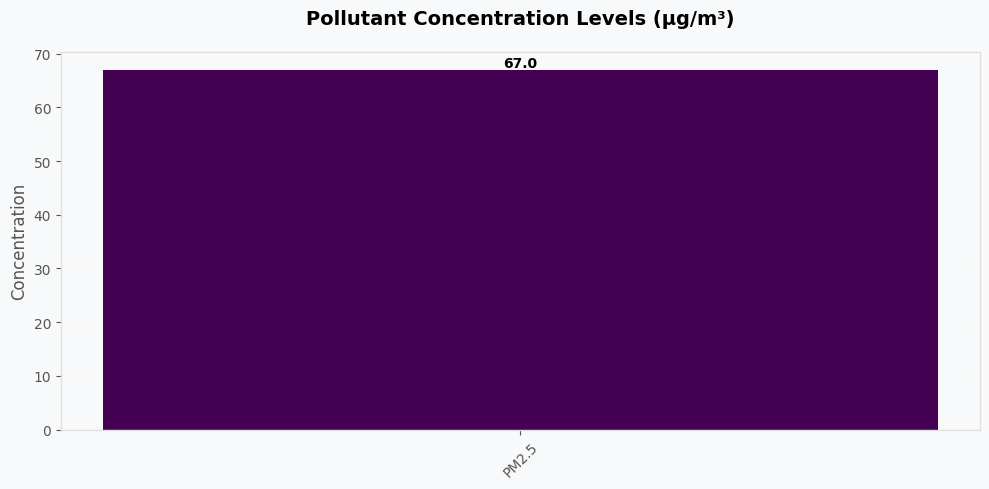

In [1]:
# First install required packages
!pip install pandas numpy folium requests ipywidgets matplotlib geopy

# Import all necessary modules
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Layout, ButtonStyle
from geopy.geocoders import Nominatim
import warnings
import time
from ipywidgets import interact, interactive, fixed, interact_manual
import json

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# API Keys (replace with your own)
OPENWEATHER_API_KEY = '91b27a9ae7f1b6dc629b6b400645fc17'
WAQI_API_KEY = '623fa8bc785e96dfb53c1607824c37ca98c1dca2'

# Constants
AQI_CATEGORIES = {
    (0, 50): {'category': 'Good', 'color': '#50C878', 'icon': '😊'},
    (51, 100): {'category': 'Moderate', 'color': '#F5D300', 'icon': '😐'},
    (101, 150): {'category': 'Unhealthy for Sensitive', 'color': '#FF9966', 'icon': '😷'},
    (151, 200): {'category': 'Unhealthy', 'color': '#FF3333', 'icon': '😨'},
    (201, 300): {'category': 'Very Unhealthy', 'color': '#9933CC', 'icon': '😱'},
    (301, 500): {'category': 'Hazardous', 'color': '#7E0023', 'icon': '☠️'}
}

# Helper functions
def get_aqi_category(aqi):
    """Get AQI category based on value"""
    for (low, high), info in AQI_CATEGORIES.items():
        if low <= aqi <= high:
            return info
    return {'category': 'Unknown', 'color': 'gray', 'icon': '❓'}

def get_recommendations_for_category(category):
    """Get health recommendations based on AQI category"""
    recommendations = {
        'Good': [
            "Air quality is excellent. Perfect for outdoor activities and exercise.",
            "Windows can be opened to refresh indoor air naturally.",
            "Great day for gardening, hiking, or outdoor sports."
        ],
        'Moderate': [
            "Air quality is acceptable for most people.",
            "Consider reducing prolonged exertion if you're unusually sensitive.",
            "Those with asthma may want to keep rescue inhalers handy."
        ],
        'Unhealthy for Sensitive': [
            "Children, elderly, and those with respiratory conditions should take precautions.",
            "Consider indoor exercise or shorter outdoor workouts.",
            "Keep windows closed if you're sensitive to air pollution."
        ],
        'Unhealthy': [
            "Everyone may begin to experience health effects.",
            "Sensitive groups should avoid outdoor exertion entirely.",
            "Consider wearing an N95 mask if you must be outside for extended periods.",
            "Run air purifiers indoors to maintain clean air."
        ],
        'Very Unhealthy': [
            "Health alert - significant risk for everyone.",
            "Avoid all outdoor physical activity if possible.",
            "Create a clean room with filtered air in your home.",
            "Those with medical conditions should monitor symptoms closely."
        ],
        'Hazardous': [
            "Emergency conditions - stay indoors with windows and doors closed.",
            "Use high-efficiency air filters and avoid activities that generate indoor pollution.",
            "If you must go outside, wear a properly fitted N95 or P100 respirator.",
            "Consider temporarily relocating if air quality doesn't improve."
        ]
    }
    return recommendations.get(category, ["No recommendations available."])

def get_location_coordinates(location_name):
    """Get latitude and longitude from location name"""
    geolocator = Nominatim(user_agent="air_quality_monitor")
    try:
        location = geolocator.geocode(location_name)
        if location:
            return location.latitude, location.longitude
        return None
    except Exception as e:
        print(f"Error getting coordinates: {str(e)}")
        return None

# Data fetching functions
def fetch_realtime_aqi(lat, lon):
    """Fetch real-time air quality data"""
    try:
        url = f"https://api.waqi.info/feed/geo:{lat};{lon}/?token={WAQI_API_KEY}"
        response = requests.get(url, timeout=10)
        data = response.json()
        
        if data['status'] != 'ok':
            print("API returned non-OK status")
            return pd.DataFrame()
        
        iaqi = data['data']['iaqi']
        return pd.DataFrame([{
            'location': data['data']['city']['name'],
            'latitude': lat,
            'longitude': lon,
            'aqi': data['data']['aqi'],
            'pm25': iaqi.get('pm25', {}).get('v'),
            'pm10': iaqi.get('pm10', {}).get('v'),
            'o3': iaqi.get('o3', {}).get('v'),
            'no2': iaqi.get('no2', {}).get('v'),
            'so2': iaqi.get('so2', {}).get('v'),
            'co': iaqi.get('co', {}).get('v'),
            'date': datetime.now().strftime('%Y-%m-%d %H:%M')
        }])
    except Exception as e:
        print(f"Error fetching AQI data: {str(e)}")
        return pd.DataFrame()

def fetch_weather_data(lat, lon):
    """Fetch current weather data"""
    try:
        url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={OPENWEATHER_API_KEY}&units=metric"
        response = requests.get(url, timeout=10)
        data = response.json()
        return {
            'temp': data['main']['temp'],
            'feels_like': data['main']['feels_like'],
            'humidity': data['main']['humidity'],
            'pressure': data['main']['pressure'],
            'wind_speed': data['wind']['speed'],
            'wind_deg': data['wind']['deg'],
            'conditions': data['weather'][0]['description'],
            'icon': data['weather'][0]['icon']
        }
    except Exception as e:
        print(f"Error fetching weather data: {str(e)}")
        return None

def create_aqi_map(aqi_data, lat, lon):
    """Create interactive Folium map"""
    if aqi_data.empty:
        return None
    
    m = folium.Map(location=[lat, lon], zoom_start=12, tiles='cartodbpositron')
    
    # Add marker for the location
    aqi_value = aqi_data.iloc[0]['aqi']
    category = get_aqi_category(aqi_value)
    
    # Custom icon
    icon = folium.DivIcon(
        html=f"""
        <div style="
            background: {category['color']};
            width: 50px;
            height: 50px;
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            color: white;
            font-weight: bold;
            border: 3px solid white;
            box-shadow: 0 0 15px rgba(0,0,0,0.3);
            font-size: 18px;
            transition: all 0.3s ease;
        ">
            {int(aqi_value)}
        </div>
        """
    )
    
    folium.Marker(
        [lat, lon],
        popup=f"""
        <div style="min-width: 250px; font-family: 'Segoe UI', sans-serif;">
            <h4 style="margin: 5px 0; color: {category['color']}; border-bottom: 1px solid #eee; padding-bottom: 5px;">
                {aqi_data.iloc[0]['location']}
            </h4>
            <p style="margin: 5px 0; font-size: 14px;">AQI: <strong style="font-size: 16px;">{aqi_value:.0f}</strong></p>
            <p style="margin: 5px 0; font-size: 14px;">Status: <strong style="color: {category['color']}">{category['category']} {category['icon']}</strong></p>
            <p style="margin: 5px 0; font-size: 12px; color: #666;">{aqi_data.iloc[0]['date']}</p>
        </div>
        """,
        icon=icon
    ).add_to(m)
    
    # Add click functionality
    m.add_child(folium.ClickForMarker(popup="New Location"))
    
    # Add fullscreen control
    folium.plugins.Fullscreen(
        position="topright",
        title="Expand me",
        title_cancel="Exit fullscreen",
        force_separate_button=True
    ).add_to(m)
    
    return m

def create_pollutant_chart(aqi_data):
    """Create interactive pollutant chart"""
    if aqi_data.empty:
        return None
    
    pollutants = {
        'PM2.5': aqi_data.iloc[0].get('pm25'),
        'PM10': aqi_data.iloc[0].get('pm10'),
        'Ozone': aqi_data.iloc[0].get('o3'),
        'NO₂': aqi_data.iloc[0].get('no2'),
        'SO₂': aqi_data.iloc[0].get('so2'),
        'CO': aqi_data.iloc[0].get('co')
    }
    
    # Filter out None values
    pollutants = {k: v for k, v in pollutants.items() if v is not None}
    
    if not pollutants:
        return None
    
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = plt.cm.viridis(np.linspace(0, 1, len(pollutants)))
    bars = ax.bar(pollutants.keys(), pollutants.values(), color=colors)
    
    # Add interactive value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_title('Pollutant Concentration Levels (µg/m³)', fontsize=14, pad=20, fontweight='bold')
    ax.set_ylabel('Concentration', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    
    # Add a subtle background
    ax.set_facecolor('#f8f9fa')
    fig.patch.set_facecolor('#f8f9fa')
    
    # Add a border
    for spine in ax.spines.values():
        spine.set_edgecolor('#e0e0e0')
        spine.set_linewidth(1)
    
    plt.tight_layout()
    
    return fig

# Create interactive widgets with enhanced styling
location_input = widgets.Text(
    value='New York',
    placeholder='Enter city or address...',
    description='',
    layout={'width': '400px', 'height': '40px'},
    style={
        'description_width': '0px',
        'font_size': '14px',
        'padding': '8px 12px',
        'border': '1px solid #ddd',
        'border_radius': '8px',
        'box_shadow': '0 2px 4px rgba(0,0,0,0.05)'
    }
)

search_button = widgets.Button(
    description='Search Location',
    icon='search',
    button_style='primary',
    layout={'width': '160px', 'height': '40px'},
    style={
        'font_weight': 'bold',
        'text_color': 'white',
        'font_size': '14px'
    },
    tooltip='Search for location'
)

current_location_button = widgets.Button(
    description='Use My Location',
    icon='location-arrow',
    button_style='info',
    layout={'width': '180px', 'height': '40px'},
    style={
        'font_weight': 'bold',
        'text_color': 'white',
        'font_size': '14px'
    },
    tooltip='Use your current location (requires permission)'
)

refresh_button = widgets.Button(
    description='Refresh Data',
    icon='refresh',
    button_style='success',
    layout={'width': '160px', 'height': '40px'},
    style={
        'font_weight': 'bold',
        'text_color': 'white',
        'font_size': '14px'
    },
    tooltip='Refresh current location data'
)

output = widgets.Output()

# Create dashboard layout with enhanced styling
search_box = widgets.HBox(
    [location_input, search_button, current_location_button, refresh_button],
    layout=Layout(
        display='flex',
        flex_flow='row wrap',
        align_items='center',
        justify_content='center',
        gap='10px',
        padding='10px',
        margin='0 auto',
        width='auto'
    )
)

dashboard = widgets.VBox([
    widgets.HTML("""
        <div style="text-align: center; margin-bottom: 20px;">
            <h1 style="color: #2c3e50; font-family: 'Poppins', sans-serif; 
                       margin-bottom: 10px; font-weight: 600; font-size: 2.5rem;">
                <span style="color: #4CAF50;">🌍</span> Global Air Quality Monitor
            </h1>
            <p style="color: #7f8c8d; font-family: 'Poppins', sans-serif; 
                      margin-top: 0; font-size: 1.1rem; max-width: 800px; margin: 0 auto;">
                Real-time air quality insights with health recommendations and pollution analytics
            </p>
        </div>
    """),
    search_box,
    output
], layout=Layout(
    width='100%',
    max_width='1200px',
    margin='0 auto',
    padding='20px'
))

# Display the initial dashboard
display(dashboard)

def update_dashboard(location_name=None, button=None):
    """Update the dashboard with new data"""
    with output:
        clear_output()
        
        # Show loading animation
        display(HTML("""
            <div id="loading" style="text-align: center; padding: 40px;">
                <div style="display: inline-block; width: 50px; height: 50px; border: 5px solid #f3f3f3;
                            border-top: 5px solid #4CAF50; border-radius: 50%; animation: spin 1s linear infinite;"></div>
                <p style="font-family: 'Poppins', sans-serif; color: #555; margin-top: 15px; font-size: 16px;">
                    Fetching latest air quality data...
                </p>
            </div>
            <style>
                @keyframes spin {
                    0% { transform: rotate(0deg); }
                    100% { transform: rotate(360deg); }
                }
            </style>
        """))
        
        # Handle button object being passed
        if isinstance(location_name, widgets.Button):
            location_name = location_input.value
            
        # Get input values
        if location_name is None:
            location_name = location_input.value
            
        # Validate input
        if not isinstance(location_name, str) or len(location_name.strip()) < 2:
            display(HTML(f"""
                <div style="color: #e74c3c; padding: 30px; text-align: center; 
                           font-family: 'Poppins', sans-serif; background: #fdecea;
                           border-radius: 10px; margin: 20px; box-shadow: 0 4px 6px rgba(0,0,0,0.05);">
                    <div style="font-size: 48px; margin-bottom: 10px;">⚠️</div>
                    <h3 style="margin-top: 0;">Invalid Location</h3>
                    <p>Please enter a valid location name (at least 2 characters).</p>
                </div>
            """))
            return
        
        # Get coordinates from location name
        coords = get_location_coordinates(location_name)
        if not coords:
            display(HTML(f"""
                <div style="color: #e74c3c; padding: 30px; text-align: center; 
                           font-family: 'Poppins', sans-serif; background: #fdecea;
                           border-radius: 10px; margin: 20px; box-shadow: 0 4px 6px rgba(0,0,0,0.05);">
                    <div style="font-size: 48px; margin-bottom: 10px;">❌</div>
                    <h3 style="margin-top: 0;">Location Not Found</h3>
                    <p>We couldn't find "{location_name}". Please try another search.</p>
                    <p style="font-size: 14px; color: #777;">Tip: Try being more specific (e.g., "Paris, France")</p>
                </div>
            """))
            return
            
        lat, lon = coords
        
        # Fetch data
        aqi_data = fetch_realtime_aqi(lat, lon)
        weather_data = fetch_weather_data(lat, lon)
        
        if aqi_data.empty:
            display(HTML(f"""
                <div style="color: #e74c3c; padding: 30px; text-align: center; 
                           font-family: 'Poppins', sans-serif; background: #fdecea;
                           border-radius: 10px; margin: 20px; box-shadow: 0 4px 6px rgba(0,0,0,0.05);">
                    <div style="font-size: 48px; margin-bottom: 10px;">⚠️</div>
                    <h3 style="margin-top: 0;">Data Unavailable</h3>
                    <p>No air quality data available for this location.</p>
                    <p style="font-size: 14px; color: #777;">Try a nearby major city or check back later.</p>
                </div>
            """))
            return
            
        current_aqi = aqi_data.iloc[0]['aqi']
        category = get_aqi_category(current_aqi)
        if not coords:
            display
        
        # Get wind direction
        if weather_data and 'wind_deg' in weather_data:
            wind_deg = weather_data['wind_deg']
            directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
            wind_dir = directions[round(wind_deg / 45) % 8]
        else:
            wind_dir = 'N/A'
        
        # Format temperature with degree symbol
        temp_formatted = f"{weather_data['temp']:.1f}°C" if weather_data else "N/A"
        feels_like_formatted = f"{weather_data['feels_like']:.1f}°C" if weather_data else "N/A"
        
        # Create dashboard HTML
        html = f"""
        <style>
            @import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;500;600;700&display=swap');
            
            .dashboard-container {{
                font-family: 'Poppins', sans-serif;
                max-width: 1200px;
                margin: 0 auto;
                padding: 0 15px;
                color: #34495e;
            }}
            
            .card {{
                background: white;
                border-radius: 12px;
                box-shadow: 0 6px 15px rgba(0,0,0,0.05);
                padding: 25px;
                margin-bottom: 25px;
                transition: transform 0.3s ease, box-shadow 0.3s ease;
                border: 1px solid rgba(0,0,0,0.05);
            }}
            
            .card:hover {{
                transform: translateY(-5px);
                box-shadow: 0 12px 20px rgba(0,0,0,0.1);
            }}
            
            .aqi-display {{
                display: flex;
                align-items: center;
                justify-content: space-between;
                margin-bottom: 25px;
                gap: 30px;
            }}
            
            .aqi-value-container {{
                position: relative;
                min-width: 120px;
            }}
            
            .aqi-value {{
                background: {category['color']};
                color: white;
                width: 120px;
                height: 120px;
                border-radius: 50%;
                display: flex;
                align-items: center;
                justify-content: center;
                font-size: 42px;
                font-weight: bold;
                box-shadow: 0 8px 15px rgba(0,0,0,0.1);
                transition: all 0.3s ease;
                position: relative;
                z-index: 1;
            }}
            
            .aqi-value:hover {{
                transform: scale(1.05) rotate(5deg);
                box-shadow: 0 12px 20px rgba(0,0,0,0.15);
            }}
            
            .aqi-value::after {{
                content: '';
                position: absolute;
                top: -5px;
                left: -5px;
                right: -5px;
                bottom: -5px;
                border-radius: 50%;
                border: 2px dashed {category['color']};
                opacity: 0.5;
                z-index: -1;
                animation: pulse 2s infinite;
            }}
            
            .aqi-info {{
                flex: 1;
                padding: 15px;
                background: #f9f9f9;
                border-radius: 10px;
                border-left: 4px solid {category['color']};
            }}
            
            .aqi-category {{
                font-size: 28px;
                font-weight: 600;
                margin-bottom: 5px;
                color: {category['color']};
                display: flex;
                align-items: center;
                gap: 10px;
            }}
            
            .weather-info {{
                display: flex;
                align-items: center;
                margin-top: 10px;
                background: #f5f9ff;
                padding: 15px;
                border-radius: 10px;
                border-left: 4px solid #4dabf7;
            }}
            
            .weather-icon {{
                font-size: 24px;
                margin-right: 10px;
            }}
            
            .recommendation-card {{
                background: #f8f9fa;
                border-left: 4px solid {category['color']};
                padding: 18px;
                margin-bottom: 15px;
                border-radius: 8px;
                transition: all 0.3s ease;
                box-shadow: 0 2px 5px rgba(0,0,0,0.03);
            }}
            
            .recommendation-card:hover {{
                background: #f1f3f5;
                transform: translateX(5px);
            }}
            
            .pollutant-chart {{
                margin-top: 20px;
            }}
            
            .map-container {{
                height: 500px;
                border-radius: 12px;
                overflow: hidden;
                box-shadow: 0 4px 12px rgba(0,0,0,0.08);
                border: 1px solid rgba(0,0,0,0.05);
            }}
            
            .section-title {{
                color: #2c3e50;
                border-bottom: 2px solid #f1f3f5;
                padding-bottom: 12px;
                margin-top: 0;
                margin-bottom: 20px;
                font-weight: 600;
                font-size: 20px;
                display: flex;
                align-items: center;
                gap: 10px;
            }}
            
            .section-title::before {{
                content: '';
                display: inline-block;
                width: 8px;
                height: 25px;
                background: {category['color']};
                border-radius: 4px;
            }}
            
            .two-column {{
                display: flex;
                gap: 25px;
                margin-top: 25px;
            }}
            
            .column {{
                flex: 1;
            }}
            
            .metric-card {{
                background: #f8f9fa;
                padding: 15px;
                border-radius: 8px;
                margin-bottom: 10px;
                display: flex;
                align-items: center;
                gap: 15px;
            }}
            
            .metric-icon {{
                font-size: 24px;
                color: #555;
            }}
            
            .metric-value {{
                font-size: 20px;
                font-weight: 600;
                color: #2c3e50;
            }}
            
            .metric-label {{
                font-size: 14px;
                color: #7f8c8d;
            }}
            
            .aqi-scale-item {{
                display: flex;
                align-items: center;
                padding: 10px 15px;
                margin-bottom: 8px;
                border-radius: 6px;
                background: #f8f9fa;
                transition: all 0.2s ease;
            }}
            
            .aqi-scale-item:hover {{
                transform: translateX(5px);
                box-shadow: 0 3px 8px rgba(0,0,0,0.05);
            }}
            
            .aqi-scale-color {{
                width: 25px;
                height: 25px;
                border-radius: 50%;
                margin-right: 15px;
                flex-shrink: 0;
            }}
            
            .aqi-scale-range {{
                font-weight: 500;
                min-width: 80px;
            }}
            
            .aqi-scale-label {{
                flex: 1;
            }}
            
            .location-header {{
                display: flex;
                justify-content: space-between;
                align-items: center;
                margin-bottom: 15px;
            }}
            
            .location-title {{
                margin: 0;
                color: #2c3e50;
                font-size: 28px;
                font-weight: 600;
            }}
            
            .location-time {{
                color: #7f8c8d;
                font-size: 14px;
                background: #f1f3f5;
                padding: 5px 10px;
                border-radius: 20px;
            }}
            
            @keyframes pulse {{
                0% {{ transform: scale(1); opacity: 0.5; }}
                50% {{ transform: scale(1.05); opacity: 0.3; }}
                100% {{ transform: scale(1); opacity: 0.5; }}
            }}
            
            @media (max-width: 768px) {{
                .two-column {{
                    flex-direction: column;
                }}
                
                .aqi-display {{
                    flex-direction: column;
                    align-items: stretch;
                }}
                
                .aqi-value-container {{
                    align-self: center;
                    margin-bottom: 20px;
                }}
                
                .map-container {{
                    height: 350px;
                }}
                
                .location-header {{
                    flex-direction: column;
                    align-items: flex-start;
                    gap: 10px;
                }}
            }}
        </style>
        
        <div class="dashboard-container">
            <!-- Location and AQI Card -->
            <div class="card">
                <div class="location-header">
                    <h1 class="location-title">{aqi_data.iloc[0]['location']}</h1>
                    <div class="location-time">
                        <i class="far fa-clock"></i> {aqi_data.iloc[0]['date']}
                    </div>
                </div>
                
                <div class="aqi-display">
                    <div class="aqi-value-container">
                        <div class="aqi-value">
                            {int(current_aqi)}
                        </div>
                    </div>
                    
                    <div class="aqi-info">
                        <div class="aqi-category">
                            {category['icon']} {category['category']}
                        </div>
                        <p style="margin: 5px 0; color: #7f8c8d; font-size: 16px;">Air Quality Index</p>
                        <p style="margin: 5px 0; font-size: 14px; color: #555;">
                            {get_recommendations_for_category(category['category'])[0]}
                        </p>
                    </div>
                    
                    <div style="min-width: 250px;">
                        {f'''<div class="weather-info">
                            <img src="http://openweathermap.org/img/wn/{weather_data['icon']}@2x.png" 
                                 alt="{weather_data['conditions']}" width="70" style="margin-right: 15px;">
                            <div>
                                <div style="font-size: 28px; font-weight: bold; color: #2c3e50;">
                                    {temp_formatted}
                                </div>
                                <div style="color: #555; text-transform: capitalize; font-size: 15px;">
                                    {weather_data['conditions']}
                                </div>
                            </div>
                        </div>''' if weather_data else ''}
                    </div>
                </div>
                
                <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 15px; margin-top: 15px;">
                    <div class="metric-card">
                        <div class="metric-icon">💧</div>
                        <div>
                            <div class="metric-value">{weather_data['humidity'] if weather_data else 'N/A'}%</div>
                            <div class="metric-label">Humidity</div>
                        </div>
                    </div>
                    
                    <div class="metric-card">
                        <div class="metric-icon">🌬️</div>
                        <div>
                            <div class="metric-value">{f"{weather_data['wind_speed']} m/s {wind_dir}" if weather_data else 'N/A'}</div>
                            <div class="metric-label">Wind Speed</div>
                        </div>
                    </div>
                    
                    <div class="metric-card">
                        <div class="metric-icon">🌡️</div>
                        <div>
                            <div class="metric-value">{feels_like_formatted}</div>
                            <div class="metric-label">Feels Like</div>
                        </div>
                    </div>
                    
                    <div class="metric-card">
                        <div class="metric-icon">⏲️</div>
                        <div>
                            <div class="metric-value">{f"{weather_data['pressure']} hPa" if weather_data else 'N/A'}</div>
                            <div class="metric-label">Pressure</div>
                        </div>
                    </div>
                </div>
            </div>
            
            <div class="two-column">
                <div class="column">
                    <!-- Recommendations Card -->
                    <div class="card">
                        <h3 class="section-title">Health Recommendations</h3>
        """
        
        for rec in get_recommendations_for_category(category['category']):
            html += f"""
                        <div class="recommendation-card">
                            <p style="margin: 0; font-size: 15px; line-height: 1.5;">{rec}</p>
                        </div>
            """
        
        html += """
                    </div>
                    
                    <!-- Pollutant Levels Card -->
                    <div class="card">
                        <h3 class="section-title">Pollutant Levels</h3>
                        <div class="pollutant-chart">
        """
        
        # Add the pollutant chart
        pollutant_chart = create_pollutant_chart(aqi_data)
        if pollutant_chart:
            display(pollutant_chart)
        else:
            html += """
                            <div style="text-align: center; padding: 30px; background: #f8f9fa; border-radius: 8px;">
                                <div style="font-size: 48px; color: #ccc; margin-bottom: 15px;">📊</div>
                                <p style="color: #7f8c8d; margin: 0;">No pollutant data available</p>
                            </div>
            """
        
        html += """
                        </div>
                    </div>
                </div>
                
                <div class="column">
                    <!-- Map Card -->
                    <div class="card" style="padding: 0; overflow: hidden;">
                        <div class="map-container">
        """
        
        # Add the map
        aqi_map = create_aqi_map(aqi_data, lat, lon)
        if aqi_map:
            display(aqi_map)
        else:
            html += """
                            <div style="text-align: center; padding: 40px; background: #f8f9fa;">
                                <div style="font-size: 48px; color: #ccc; margin-bottom: 15px;">🗺️</div>
                                <p style="color: #7f8c8d; margin: 0;">No map data available</p>
                            </div>
            """
        
        html += """
                        </div>
                    </div>
                    
                    <!-- AQI Scale Card -->
                    <div class="card">
                        <h3 class="section-title">AQI Scale Reference</h3>
                        
        """
        
        # Add AQI scale items
        for (low, high), info in AQI_CATEGORIES.items():
            html += f"""
                        <div class="aqi-scale-item">
                            <div class="aqi-scale-color" style="background: {info['color']};"></div>
                            <div class="aqi-scale-range">{low}-{high}</div>
                            <div class="aqi-scale-label">{info['category']} {info['icon']}</div>
                        </div>
            """
        
        html += """
                    </div>
                </div>
            </div>
            
            <!-- Footer -->
            <div style="text-align: center; margin: 30px 0; color: #7f8c8d; font-size: 13px;">
                <p>Data provided by World Air Quality Index and OpenWeatherMap APIs</p>
                <p>Last updated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            </div>
        </div>
        
        <script>
            // Simple animation for elements when they come into view
            document.querySelectorAll('.card').forEach((card, index) => {{
                setTimeout(() => {{
                    card.style.opacity = '1';
                    card.style.transform = 'translateY(0)';
                }}, index * 100);
            }});
            
            // Initially set cards to be slightly transparent and moved up
            document.querySelectorAll('.card').forEach(card => {{
                card.style.opacity = '0';
                card.style.transform = 'translateY(20px)';
                card.style.transition = 'opacity 0.5s ease, transform 0.5s ease';
            }});
        </script>
        """
        
        display(HTML(html))

def get_current_location(button):
    """Get current location using browser geolocation"""
    with output:
        clear_output()
        display(HTML("""
            <div style="text-align: center; padding: 40px; font-family: 'Poppins', sans-serif;">
                <div style="font-size: 48px; margin-bottom: 20px;">📍</div>
                <h3 style="margin-top: 0; color: #2c3e50;">Location Access Note</h3>
                <p style="color: #555; max-width: 500px; margin: 0 auto 20px;">
                    In a Jupyter notebook, we can't directly access your browser's location.
                    Please enter your location manually or use this alternative:
                </p>
                <div style="margin-top: 20px;">
                    <button onclick="
                        navigator.geolocation.getCurrentPosition(
                            function(pos) {
                                const lat = pos.coords.latitude;
                                const lon = pos.coords.longitude;
                                alert('Your coordinates: ' + lat + ', ' + lon + 
                                      '\\nPlease enter these manually in the search box.');
                            },
                            function(err) {
                                alert('Error getting location: ' + err.message);
                            }
                        );
                    " style="
                        background: #4CAF50;
                        color: white;
                        border: none;
                        padding: 10px 20px;
                        border-radius: 5px;
                        font-size: 16px;
                        cursor: pointer;
                    ">
                        Try Browser Location
                    </button>
                </div>
            </div>
        """))

# Set up button click handlers
search_button.on_click(update_dashboard)
current_location_button.on_click(get_current_location)
refresh_button.on_click(lambda b: update_dashboard(location_input.value))

# Add interactive search
def handle_location_change(change):
    if len(change['new']) > 3:  # Only search after 3 characters
        update_dashboard(change['new'])

location_input.observe(handle_location_change, names='value')

# Initial display with a default location
update_dashboard('New York')